In [ ]:
!pip install -qq aicrowd-cli==0.1 #getting the aicrowd cli

     |████████████████████████████████| 40kB 5.9MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
     |████████████████████████████████| 174kB 41.6MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 204kB 50.0MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 


In [ ]:
API_KEY = 'PERSONAL API KEY' #authentication 
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [ ]:
!aicrowd dataset download --challenge f1-team-classification -j 3 #getting the challenge data

train.csv: 100% 569k/569k [00:00<00:00, 1.84MB/s]
train.zip:   0% 0.00/391M [00:00<?, ?B/s]
sample_submission.csv:   0% 0.00/134k [00:00<?, ?B/s]
sample_submission.csv: 100% 134k/134k [00:00<00:00, 726kB/s]

val.csv: 100% 52.9k/52.9k [00:00<00:00, 779kB/s]

test.zip:   0% 0.00/97.7M [00:00<?, ?B/s]

train.zip:   9% 33.6M/391M [00:01<00:16, 21.7MB/s]

val.zip: 100% 38.9M/38.9M [00:01<00:00, 29.7MB/s]
train.zip:  52% 201M/391M [00:05<00:05, 35.4MB/s]
train.zip:  77% 302M/391M [00:08<00:02, 38.5MB/s]
train.zip:  95% 369M/391M [00:10<00:00, 32.6MB/s]
test.zip: 100% 97.7M/97.7M [00:10<00:00, 9.49MB/s]
train.zip: 100% 391M/391M [00:11<00:00, 35.0MB/s]


In [ ]:
!rm -rf data
!mkdir data

!unzip train.zip  -d data/train
!unzip val.zip -d data/val
!unzip test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: data/test/5042.jpg      
  inflating: data/test/5043.jpg      
  inflating: data/test/5045.jpg      
  inflating: data/test/5046.jpg      
  inflating: data/test/5047.jpg      
  inflating: data/test/5048.jpg      
  inflating: data/test/5049.jpg      
  inflating: data/test/505.jpg       
  inflating: data/test/5050.jpg      
  inflating: data/test/5051.jpg      
  inflating: data/test/5052.jpg      
  inflating: data/test/5053.jpg      
  inflating: data/test/5054.jpg      
  inflating: data/test/5055.jpg      
  inflating: data/test/5056.jpg      
  inflating: data/test/5057.jpg      
  inflating: data/test/5058.jpg      
  inflating: data/test/5059.jpg      
  inflating: data/test/506.jpg       
  inflating: data/test/5060.jpg      
  inflating: data/test/5061.jpg      
  inflating: data/test/5063.jpg      
  inflating: data/test/5064.jpg      
  inflating: data/test/5065.jpg      
  inflating: data/test/5066.jpg      

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import cv2
import random
import os
from PIL import Image
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras.applications.resnet50 import ResNet50
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [ ]:
train_df = pd.read_csv('/content/data/train.csv')
train_df.head()

,ImageID,label
0,0,redbull
1,1,mercedes
2,2,redbull
3,3,redbull
4,4,redbull


In [ ]:
train_path = '/content/data/train'
validation_path = '/content/data/val'
test_path = '/content/data/test'

In [ ]:
train_df['ImageID'] = train_df['ImageID'].astype(str)+".jpg"
train_df['label'] = train_df['label'].astype('string')
train_df

,ImageID,label
0,0.jpg,redbull
1,1.jpg,mercedes
2,2.jpg,redbull
3,3.jpg,redbull
4,4.jpg,redbull
...,...,...
39995,39995.jpg,redbull
39996,39996.jpg,redbull
39997,39997.jpg,redbull
39998,39998.jpg,redbull


In [ ]:
def load_images():
  plt.figure(figsize=(20,10))
  for i in range(5):
    sample = random.choice(os.listdir(train_path))
    plt.subplot(1,10,i+1)
    img = load_img(train_path+"/"+sample)
    plt.imshow(img)
  plt.show()

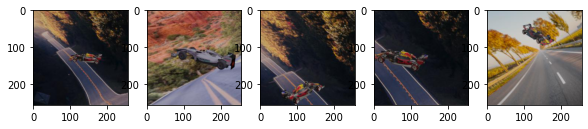

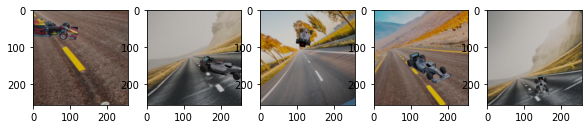

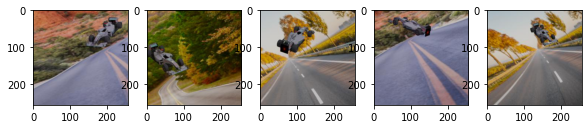

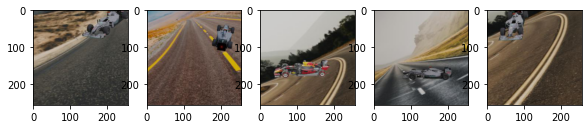

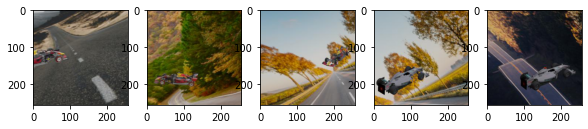

In [ ]:
for i in range(5):
  load_images()

In [ ]:
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         zoom_range = 0.2,
                                         horizontal_flip = True,
                                         validation_split = 0.2)
val_datagen = image.ImageDataGenerator(rescale=1./255,
                                       validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    directory = train_path,
                                                    x_col = 'ImageID',
                                                    y_col = 'label',
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = 64,
                                                    subset = 'training')
val_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    directory = validation_path,
                                                    x_col = 'ImageID',
                                                    y_col = 'label',
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = 64,
                                                    subset = 'validation')

Found 32000 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 36000 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
"""model = tf.keras.Sequential()
model.add(VGG16(include_top = False,weights = 'imagenet',input_shape= (224,224,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(2,activation = 'softmax'))
optimizer = Adam(lr = 0.001)
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
             metrics = ['accuracy'])
model.summary()"""

"model = tf.keras.Sequential()\nmodel.add(VGG16(include_top = False,weights = 'imagenet',input_shape= (224,224,3)))\nmodel.add(BatchNormalization())\nmodel.add(Flatten())\nmodel.add(Dense(2,activation = 'softmax'))\noptimizer = Adam(lr = 0.001)\nmodel.compile(loss = 'binary_crossentropy',\n              optimizer = optimizer,\n             metrics = ['accuracy'])\nmodel.summary()"

In [ ]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.layers[0].trainable = False
optimizer = Adam(lr = 0.001)
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
             metrics = ['accuracy'])

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4

In [ ]:
epochs = 10
batch_size = 64
history = model.fit_generator(train_generator,epochs = epochs,validation_data = val_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 410s 748ms/step - loss: 0.7040 - accuracy: 0.6423 - val_loss: 0.8396 - val_accuracy: 0.5025
Epoch 2/10
500/500 [==============================] - 371s 741ms/step - loss: 0.5238 - accuracy: 0.7431 - val_loss: 1.0256 - val_accuracy: 0.4913
Epoch 3/10
500/500 [==============================] - 369s 738ms/step - loss: 0.4594 - accuracy: 0.7812 - val_loss: 1.3731 - val_accuracy: 0.4913
Epoch 4/10
500/500 [==============================] - 367s 734ms/step - loss: 0.4415 - accuracy: 0.7918 - val_loss: 1.4055 - val_accuracy: 0.4888
Epoch 5/10
500/500 [==============================] - 366s 731ms/step - loss: 0.4032 - accuracy: 0.8145 - val_loss: 1.5211 - val_accuracy: 0.4688
Epoch 6/10
500/500 [==============================] - 370s 740ms/step - loss: 0.3738 - accuracy: 0.8326 - val_loss: 1.5281 - val_accuracy: 0.4863
Epoch 7/10
500/500 [==============================] - 366s 732ms/step - loss: 0.3584 - accuracy: 0.8379 - val_loss: 1.6531 -

Text(0.5, 0, 'epoch')

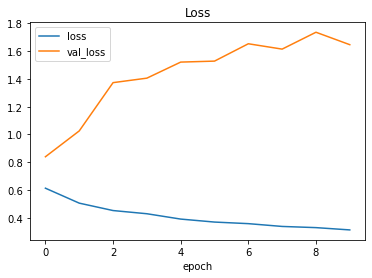

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

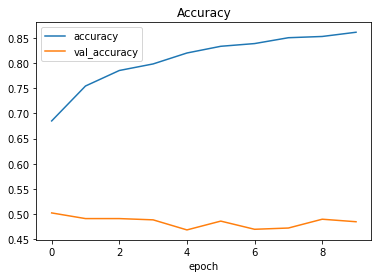

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
preds = []
ss = pd.read_csv('/content/data/sample_submission.csv')

for image in ss.ImageID:
    img = tf.keras.preprocessing.image.load_img('/content/data/test/' + str(image)+'.jpg')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
    img = tf.reshape(img, (-1, 224, 224, 3))
    
    prediction = model.predict(img/255)
    class_names = ['rebull','mercedes']
    
    preds.append(class_names[np.argmax(prediction)])
    


my_submission = pd.DataFrame({'ImageID': ss.ImageID, 'label': preds})
my_submission.to_csv('my_submission_f1blitz_1.csv', index=False) 

In [ ]:
my_submission.head()

,ImageID,label
0,0,rebull
1,1,rebull
2,2,mercedes
3,3,mercedes
4,4,rebull
